# Attempt HMM on temporal and spactial data 

See if we can do the same as with the other HMMs, but with differnet data.
Can then see which points should be reclassified, and compare to what the other model says.
Can then take the intersection of these reclassifications to be sure.

In [1]:
# imports
from hmmlearn import hmm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt


In [2]:
# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [223]:
# THis cell fills in the gaps of time data we have by filling in the gaps with the above data.
# This is accurate as no new data means the mouse hasnt mooved.

# Convet times to int
df_lab_time = df_lab[['time', 'x', 'y', 'turkId']]
df_lab_time['time'] = df_lab_time['time'].apply(np.floor).astype(int)

values = []

for ID in df_lab_time['turkId'].unique():

    #f = df.drop_duplicates(subset='favorite_color', keep="first")

    ID_data = df_lab_time[df_lab_time['turkId'] == ID].drop_duplicates(subset='time', keep='first')

    print(ID_data['time'].max())

    ID_data['time'] = pd.to_datetime(ID_data['time'], unit='h')
    ID_data = ID_data.set_index('time').resample('h').first() # Fills in missing time values

    ID_data = ID_data.fillna(method='ffill')    # Fills in missing data values with previous entery

    ID_data = ID_data.reset_index().reset_index() # reset index to ints 0 to x
    ID_data['time2'] = ID_data['index']
    ID_data = ID_data[['time2', 'x', 'y', 'turkId']]        # removes stupid columns and rename
    ID_data = ID_data.rename(columns={'time2': 'time'})
    values.extend(ID_data.to_numpy())

df_lab_time_series = pd.DataFrame(values).rename(columns={0:'time', 1:'x', 2:'y', 3:'turkId'})
df_lab_time_series

979
629
629
421
148
362
1046
243
344
290
435
435
275
275


,time,x,y,turkId
0,0,397.0,647.0,ID1
1,1,426.0,642.0,ID1
2,2,382.0,644.0,ID1
3,3,382.0,644.0,ID1
4,4,382.0,644.0,ID1
...,...,...,...,...
130049,271,575.0,891.0,ID18
130050,272,561.0,922.0,ID18
130051,273,547.0,854.0,ID18
130052,274,942.0,1248.0,ID18


In [226]:
# Convet times to int
df_turk_time = df_turk[['time', 'x', 'y', 'turkId']]
df_turk_time['time'] = df_turk_time['time'].apply(np.floor).astype(int)

values = []

for ID in df_turk_time['turkId'].unique():

    #f = df.drop_duplicates(subset='favorite_color', keep="first")
    try:
        ID_data = df_turk_time[df_turk_time['turkId'] == ID].drop_duplicates(subset='time', keep='first')

        print(ID_data['time'].max())


        ID_data['time'] = pd.to_datetime(ID_data['time'], unit='h')
        ID_data = ID_data.set_index('time').resample('h').first() # Fills in missing time values

        ID_data = ID_data.fillna(method='ffill')    # Fills in missing data values with previous entery

        ID_data = ID_data.reset_index().reset_index() # reset index to ints 0 to x
        ID_data['time2'] = ID_data['index']
        ID_data = ID_data[['time2', 'x', 'y', 'turkId']]        # removes stupid columns and rename
        ID_data = ID_data.rename(columns={'time2': 'time'})
        values.extend(ID_data.to_numpy())
    except:
        print('Something went wrong somewhere, TODO fix')

df_turk_time_series = pd.DataFrame(values).rename(columns={0:'time', 1:'x', 2:'y', 3:'turkId'})
df_turk_time_series

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
121
83
138
452
81
262
290
317
Something went wrong somewhere, TODO fix
273
295
146
423
188
367
227
73
234
183
134
359
149
452
76
154
984
351
344
424
318
617
411
300
296
348
179
667
269
344
136
120
575
251
1100
438
444
507
421
897
216
144
224
350
303
119
395
271
553
425
118
640
197
110
513
289
337
935
830
242
193
171
328
263
706
369
116
560
230
293
34
128
104
275
372
378
280
468
332
288
478
193
338
969
1591
309
144
176
280
273
292
274
341
473
490
245
124
165
517
132
133
87
227
167
159
233
298
301
532
364
230
68
637
202
277
393
228
68
154
413
149
573
273
228

,time,x,y,turkId
0,0,477.0,405.0,A35YFAFWP33C70
1,1,479.0,405.0,A35YFAFWP33C70
2,2,543.0,403.0,A35YFAFWP33C70
3,3,594.0,402.0,A35YFAFWP33C70
4,4,594.0,402.0,A35YFAFWP33C70
...,...,...,...,...
9749624,254,682.0,1178.0,A15781PHGW377Y
9749625,255,678.0,1173.0,A15781PHGW377Y
9749626,256,617.0,1405.0,A15781PHGW377Y
9749627,257,617.0,1799.0,A15781PHGW377Y


In [229]:
df_turk_time_series

,time,x,y,turkId
0,0,477.0,405.0,A35YFAFWP33C70
1,1,479.0,405.0,A35YFAFWP33C70
2,2,543.0,403.0,A35YFAFWP33C70
3,3,594.0,402.0,A35YFAFWP33C70
4,4,594.0,402.0,A35YFAFWP33C70
...,...,...,...,...
9749624,254,682.0,1178.0,A15781PHGW377Y
9749625,255,678.0,1173.0,A15781PHGW377Y
9749626,256,617.0,1405.0,A15781PHGW377Y
9749627,257,617.0,1799.0,A15781PHGW377Y


In [235]:
# want to have everything in one long array.
# But then we need to create the lengths array.

lab_lengths = []
for ID in df_lab_time_series['turkId'].unique():
    print(len(lab_lengths))
    length_for_ID = len( df_lab_time_series[df_lab_time_series['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_turk_time_series['turkId'].unique():
    print(len(turk_lengths))
    length_for_ID = len( df_turk_time_series[df_turk_time_series['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
26

In [236]:
# reorganise data for hmm input
data_lab = df_lab_time_series[['x', 'y']].to_numpy().reshape(-1, 2).astype(np.int)
data_turk = df_turk_time_series[['x', 'y']].to_numpy().reshape(-1, 2).astype(np.int)

In [237]:
lab_model = hmm.GaussianHMM(n_components=8, random_state=0, n_iter=50, verbose=True).fit(data_lab, lab_lengths)

1    -1654888.5718             +nan
         2    -1119956.7937     +534931.7781
         3     -166480.7811     +953476.0125
         4     1399409.9562    +1565890.7373
         5     1488785.2836      +89375.3274
         6     1662326.7058     +173541.4222
         7     1665211.2721       +2884.5663
         8     1665219.8874          +8.6153
         9     1665223.3345          +3.4472
        10     1665223.7031          +0.3686
        11     1665222.6750          -1.0282


In [239]:
lab_model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=8, n_iter=50, params='stmc',
            random_state=0, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
            verbose=True)

In [238]:
turk_model = hmm.GaussianHMM(n_components=8, random_state=0, n_iter=50, verbose=True).fit(data_turk, turk_lengths)

1  -137560737.0345             +nan
         2  -128043419.6931    +9517317.3414
         3  -119176777.2403    +8866642.4528
         4  -113054724.0149    +6122053.2253
         5  -107032398.2671    +6022325.7478
         6  -103969347.0681    +3063051.1990
         7  -102572778.3148    +1396568.7534
         8  -101027206.4991    +1545571.8157
         9  -100046646.8996     +980559.5995
        10   -99922839.5497     +123807.3499
        11   -99879596.6179      +43242.9318
        12   -99831010.4486      +48586.1692
        13   -99813303.9363      +17706.5123
        14   -99807863.3293       +5440.6070
        15   -99804787.3868       +3075.9426
        16   -99803398.9092       +1388.4776
        17   -99802888.1019        +510.8073
        18   -99802743.3945        +144.7074
        19   -99802697.8179         +45.5766
        20   -99802679.3575         +18.4604
        21   -99802672.5423          +6.8151
        22   -99802670.8300          +1.7123
        23   -99802

In [240]:
turk_model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=8, n_iter=50, params='stmc',
            random_state=0, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
            verbose=True)

In [0]:
# TODO try with other random states for these and other hmm.
# maybe the random itial state just makes us stuck in a local minimum

In [241]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

# Score is given as a liklihood https://web.stanford.edu/~jurafsky/slp3/A.pdf
# Somthing like summing the likelihoods of each hidden state producing the same output as the input at the same location?   
model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[-14429.934231649433,
 -10157.328655682175,
 -9481.587369166095,
 -6883.31984995555,
 -2443.5595258108033,
 -191379.89262366836,
 -12234.843656886263,
 -3115.643384239207,
 -1348246.8125174162,
 -3573.769052326119,
 -6620.464614171797,
 -7244.19454079877,
 -4618.752318551755,
 -3772.734839159295]

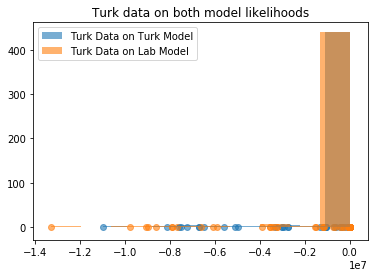

In [242]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

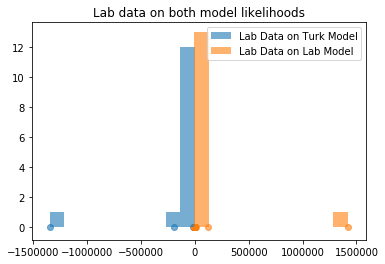

In [243]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

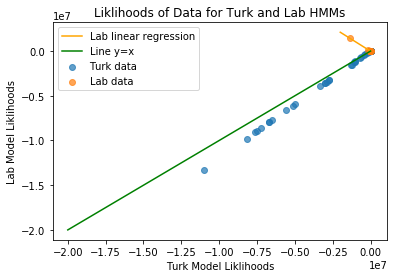

In [248]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7, label='Turk data')
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7, label='Lab data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-2000000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')

x = np.linspace(-20000000,0,100)
y = x
plt.plot(x, y, 'green', label='Line y=x')

plt.legend()

#plt.xlim(-2000000, 2000000)
#plt.ylim(-2000000, 2000000)

plt.show()

In [249]:
# Reassign samples


# Test readdign samples a different way.
# If a point is above and to the left of the orange line then we can say that the data matches the lab model compared to the turk model to the same extent as the actual lab data.

def reclassify_samples(turk_model, lab_model, data, lengths):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood
        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

def reclassify_samples_regression(turk_model, lab_model, data, lengths, reg):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood

        # Y= MX + C is equation of straight line.
        # if Y > MX + C then the point is above the line    
        # https://math.stackexchange.com/questions/324589/detecting-whether-a-point-is-above-or-below-a-slope

        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( Y > M*X + C ):
            new_classes.append(1)
        else:
            new_classes.append(0)

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

# Lab data is half classified as itself. GOOD
reclassified_lab_labels = reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)
reclassified_lab_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_lab, lab_lengths, reg)

print('Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels.count(0), reclassified_lab_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels_reg.count(0), reclassified_lab_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
0 14

REG Number of new turk labels, number of new lab labels:
4 24


In [250]:
reclassified_turk_labels = reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try turk data
reclassified_turk_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_turk, turk_lengths, reg)    # Try turk data

print('Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels.count(0), reclassified_turk_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels_reg.count(0), reclassified_turk_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
53 406

REG Number of new turk labels, number of new lab labels:
140 778


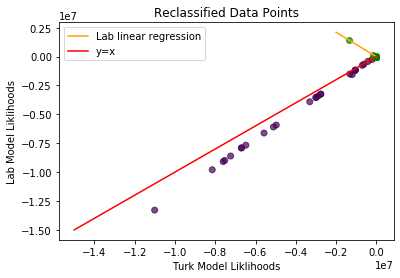

In [257]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, c='g', alpha=0.7)

plt.title('Reclassified Data Points')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-2000000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')

x = np.linspace(-15000000,100,100)
y = 1*x+0
plt.plot(x, y, 'r', label='y=x')

plt.legend()

plt.show()

Turk likelihoods  Lab likelihoods   Difference   ID
0     -14429.934232    -11491.269386 -2938.664846  ID1
1     -10157.328656     -7553.376092 -2603.952564  ID2
2      -9481.587369     -7326.120450 -2155.466920  ID3
3      -6883.319850     -4934.800378 -1948.519472  ID4
4      -2443.559526     -1759.631620  -683.927906  ID5


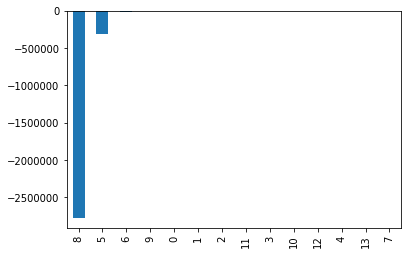

In [252]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_lab_seq['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

Turk likelihoods  Lab likelihoods   Difference              ID
0      -1818.487075     -1504.996839  -313.490236  A35YFAFWP33C70
1      -1446.599352     -1060.935696  -385.663656  A33XI8ZN4NZ0SQ
2      -2342.013183     -1773.391377  -568.621806  A1ZG7VYH0DUEXW
3      -7032.087070     -5400.650207 -1631.436863  A1RXG8RE0SJ4LC
4      -1114.889239      -927.564898  -187.324342   AUDH0P4ZHJKS2


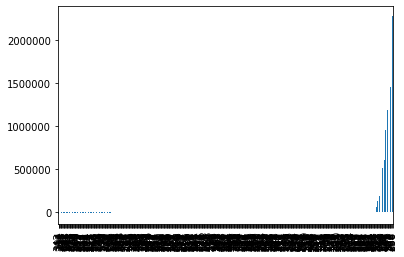

In [253]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_turk_seq['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')


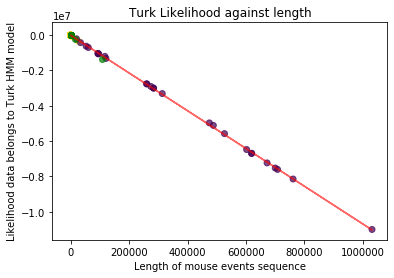

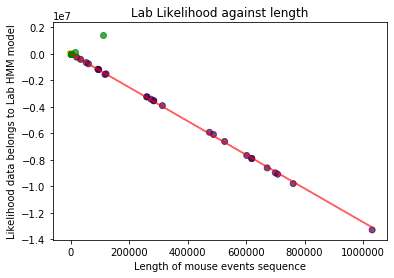

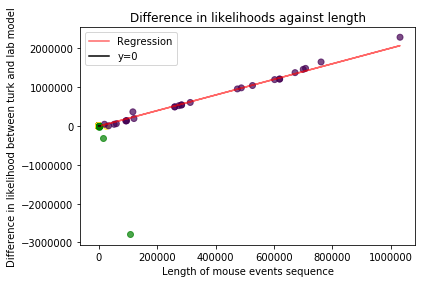

In [254]:
# Turk plot
plt.scatter(turk_lengths, df_turk_diff['Turk likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], c='g', alpha=0.7)
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()


# Lab plot
plt.scatter(turk_lengths, df_turk_diff['Lab likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], c='g', alpha=0.7)
plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Difference plot
plt.scatter(turk_lengths, df_turk_diff['Difference'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Difference'], c='g', alpha=0.7)
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6, label='Regression')

x = np.linspace(0,6000,6000)
y = 0*x
plt.plot(x, y, 'k', label='y=0')
plt.legend()

plt.show()


In [227]:
# OLD STUFF BENEATH THIS





In [5]:
# Lots of missing timestamps.
# Instead use just the order of them as before.
# Num of events is simlar to time anyway so should be fine?

df_lab_seq = df_lab[['x', 'y', 'turkId']]
lab_dups = len(df_lab_seq)-len(df_lab_seq.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab_seq) * 100}\n')
df_lab_seq = df_lab_seq.drop_duplicates()

data_lab = df_lab_seq[['x', 'y']].to_numpy().reshape(-1, 2).astype(np.int)

df_turk_seq = df_turk[['x', 'y', 'turkId']]
turk_dups = len(df_turk_seq)-len(df_turk_seq.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_turk_seq) * 100}')
df_turk_seq = df_turk_seq.drop_duplicates()

data_turk = df_turk_seq[['x', 'y']].astype('int32').to_numpy().reshape(-1, 2).astype(np.int)

# Models were more accurate when duplicate data was removed.
# TODO: try and get proper time series data
# for each turk, loop i from 0 to max time:
#   if there is no value for i+1 then add row with previous value.

Number of duplicate items in lab data: 11216
Percentage duplicate: 29.938073884262224

Number of duplicate items in turk data: 226995
Percentage duplicate: 23.320789143573954


In [6]:
# want to have everything in one long array.
# But then we need to create the lengths array.

lab_lengths = []
for ID in df_lab_seq['turkId'].unique():
    length_for_ID = len( df_lab_seq[df_lab_seq['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_turk_seq['turkId'].unique():
    length_for_ID = len( df_turk_seq[df_turk_seq['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

In [7]:
# 6 states, 50 iter = -296955

lab_model = hmm.GaussianHMM(n_components=8, random_state=0, n_iter=50, verbose=True).fit(data_lab, lab_lengths)


1     -357598.7113             +nan
         2     -330312.7784      +27285.9328
         3     -317480.8826      +12831.8958
         4     -308151.4289       +9329.4537
         5     -302530.8766       +5620.5523
         6     -301671.5162        +859.3604
         7     -300570.5648       +1100.9514
         8     -296909.3033       +3661.2616
         9     -290528.4378       +6380.8655
        10     -288701.6212       +1826.8165
        11     -288638.4074         +63.2138
        12     -288623.6847         +14.7228
        13     -288618.6327          +5.0519
        14     -288616.6587          +1.9741
        15     -288614.8804          +1.7783
        16     -288609.5461          +5.3342
        17     -288601.6686          +7.8775
        18     -288599.0700          +2.5986
        19     -288597.9746          +1.0954
        20     -288597.0981          +0.8765
        21     -288596.2833          +0.8148
        22     -288595.4612          +0.8221
        23     -288

In [8]:
# 6 states, 50 iter = -8797740

turk_model = hmm.GaussianHMM(n_components=8, random_state=0, n_iter=50, verbose=True).fit(data_turk, turk_lengths)

1   -10340211.0549             +nan
         2    -9671096.8447     +669114.2102
         3    -9264697.7371     +406399.1076
         4    -9049892.1907     +214805.5464
         5    -8971598.2620      +78293.9288
         6    -8855231.1388     +116367.1231
         7    -8769283.1059      +85948.0329
         8    -8738199.6381      +31083.4678
         9    -8693687.3429      +44512.2952
        10    -8668250.2546      +25437.0883
        11    -8664413.2816       +3836.9730
        12    -8663239.5371       +1173.7445
        13    -8662345.0079        +894.5292
        14    -8661272.2026       +1072.8053
        15    -8660000.8298       +1271.3728
        16    -8658744.1107       +1256.7191
        17    -8657841.8410        +902.2696
        18    -8657358.8855        +482.9556
        19    -8657168.1912        +190.6943
        20    -8657096.5192         +71.6720
        21    -8657066.0720         +30.4472
        22    -8657055.3113         +10.7607
        23    -8657

In [9]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

# Score is given as a liklihood https://web.stanford.edu/~jurafsky/slp3/A.pdf
# Somthing like summing the likelihoods of each hidden state producing the same output as the input at the same location?   
model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[-22649.459435306002,
 -19350.186273285395,
 -19466.64579627351,
 -6376.487184150367,
 -6003.088936409435,
 -47763.46756315109,
 -13065.51970102258,
 -4913.15176474156,
 -42153.62755972911,
 -4574.977693679633,
 -36157.7389847479,
 -36925.6797608968,
 -20744.4367301452,
 -20827.027877555283]

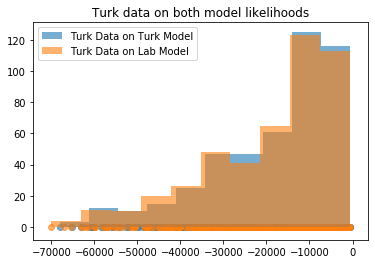

In [10]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

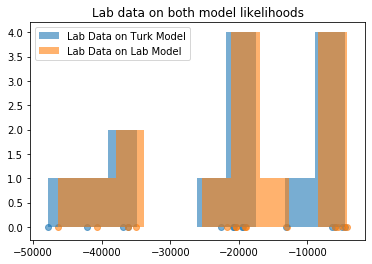

In [11]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

In [12]:
# Plotting results

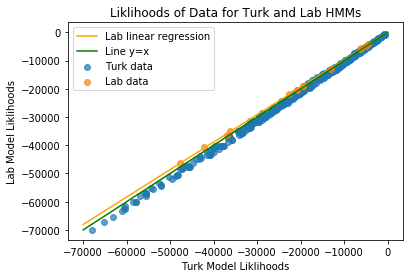

In [13]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7, label='Turk data')
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7, label='Lab data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-70000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')

x = np.linspace(-70000,0,100)
y = x
plt.plot(x, y, 'green', label='Line y=x')

plt.legend()

plt.show()

In [14]:
# Reassign samples


# Test readdign samples a different way.
# If a point is above and to the left of the orange line then we can say that the data matches the lab model compared to the turk model to the same extent as the actual lab data.

def reclassify_samples(turk_model, lab_model, data, lengths):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood
        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

def reclassify_samples_regression(turk_model, lab_model, data, lengths, reg):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood

        # Y= MX + C is equation of straight line.
        # if Y > MX + C then the point is above the line    
        # https://math.stackexchange.com/questions/324589/detecting-whether-a-point-is-above-or-below-a-slope

        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( Y > M*X + C ):
            new_classes.append(1)
        else:
            new_classes.append(0)

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

# Lab data is half classified as itself. GOOD
reclassified_lab_labels = reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)
reclassified_lab_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_lab, lab_lengths, reg)

print('Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels.count(0), reclassified_lab_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels_reg.count(0), reclassified_lab_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
0 14

REG Number of new turk labels, number of new lab labels:
6 22


In [15]:
reclassified_turk_labels = reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try turk data
reclassified_turk_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_turk, turk_lengths, reg)    # Try turk data

print('Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels.count(0), reclassified_turk_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels_reg.count(0), reclassified_turk_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
424 37

REG Number of new turk labels, number of new lab labels:
885 37


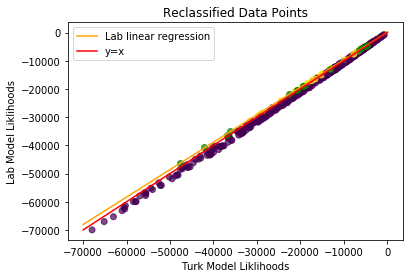

In [16]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, c='g', alpha=0.7)

plt.title('Reclassified Data Points')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-70000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')

x = np.linspace(-70000,100,100)
y = 1*x+0
plt.plot(x, y, 'r', label='y=x')

plt.legend()

plt.show()

Turk likelihoods  Lab likelihoods  Difference   ID
0     -22649.459435    -21767.683541 -881.775894  ID1
1     -19350.186273    -19009.995480 -340.190794  ID2
2     -19466.645796    -19068.973190 -397.672606  ID3
3      -6376.487184     -6038.928866 -337.558318  ID4
4      -6003.088936     -5573.871852 -429.217085  ID5


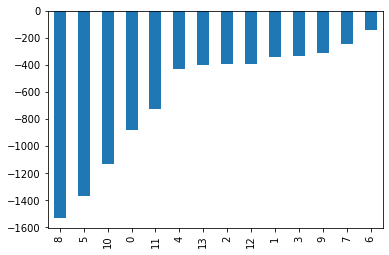

In [17]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_lab_seq['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

Turk likelihoods  Lab likelihoods   Difference              ID
0      -3314.200166     -3690.442977   376.242811  A35YFAFWP33C70
1      -6263.308024     -6556.008928   292.700904  A33XI8ZN4NZ0SQ
2     -10333.827295    -11344.501302  1010.674007  A1ZG7VYH0DUEXW
3      -6318.475649     -7145.907654   827.432004  A1RXG8RE0SJ4LC
4      -1423.138810     -1559.945872   136.807062   AUDH0P4ZHJKS2


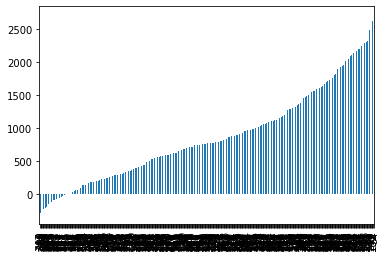

In [18]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_turk_seq['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

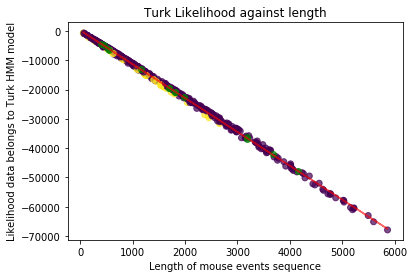

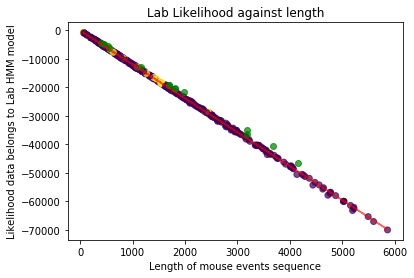

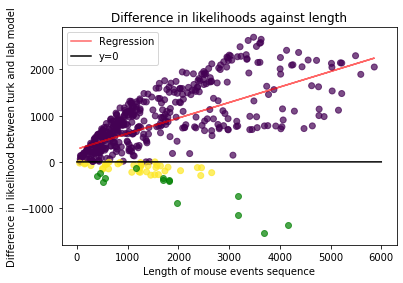

In [19]:
# Turk plot
plt.scatter(turk_lengths, df_turk_diff['Turk likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], c='g', alpha=0.7)
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()


# Lab plot
plt.scatter(turk_lengths, df_turk_diff['Lab likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], c='g', alpha=0.7)
plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Difference plot
plt.scatter(turk_lengths, df_turk_diff['Difference'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Difference'], c='g', alpha=0.7)
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6, label='Regression')

x = np.linspace(0,6000,6000)
y = 0*x
plt.plot(x, y, 'k', label='y=0')
plt.legend()

plt.show()


In [20]:
# TODO: Save df_diffs to csv to explore with tableau. 

In [21]:
# Todo: print out the turk ids of people with negative differences.
# Do the same with other HMM and take intersection.


print(len(df_turk_diff[df_turk_diff['Difference'] < 0]))

reclassified_IDs = df_turk_diff[df_turk_diff['Difference'] < 0]['ID'].to_numpy()
reclassified_IDs

37


array(['A1O2S71TYP1AFC', 'AY2U544TCVPMQ', 'A38QM2WVQ7O9MF',
       'A1WJQFUJFDCST5', 'A2FQRMIL3DSKI4', 'A20X14OMRL0YPZ',
       'A1NQZSUQPL4K17', 'A3KYFEDDBCFQU1', 'A224B7BAQ0MZSN',
       'AFWKRID53R1XA', 'ABUNAEPK8GV63', 'A2BOUSPEKZYWDO',
       'A1Q5KU5RVDE67', 'A20IXK8ZV8N72H', 'A36K11N6R2A108',
       'AE837QZ9XU1UQ', 'A2KHV2D09JAWPC', 'A16NAK9LY0HRJS',
       'AUK4KGOJP9F0H', 'AACGKQ431VQSM', 'A3BY2WDCY8YLDE',
       'A2JA8QB8PGYGHJ', 'A2M6GFFEYJ5XP', 'AJVGW8ZY3SWE4',
       'AA8NOYG0AXRJO', 'A2OMY4DX7JQVU0', 'A2SZGJMBK4LSJ1',
       'A2T9WRHFRIVAFY', 'A1M28E133E3K5X', 'A35OLDOCJQBO38',
       'A2D50KS58QB1BN', 'A36DDHDQ56N60C', 'A30QJF394U1VRY',
       'A2MCRVU8I9VNHG', 'A4PFM9Z80RXUY', 'A13BTXTJQIXWTL',
       'A3T0IC6VPU9NJY'], dtype=object)

In [22]:
new = np.array(['A1O2S71TYP1AFC', 'AY2U544TCVPMQ', 'A38QM2WVQ7O9MF',
       'A1WJQFUJFDCST5', 'A2FQRMIL3DSKI4', 'A20X14OMRL0YPZ',
       'A1NQZSUQPL4K17', 'A3KYFEDDBCFQU1', 'A224B7BAQ0MZSN',
       'AFWKRID53R1XA', 'ABUNAEPK8GV63', 'A2BOUSPEKZYWDO',
       'A1Q5KU5RVDE67', 'A20IXK8ZV8N72H', 'A36K11N6R2A108',
       'AE837QZ9XU1UQ', 'A2KHV2D09JAWPC', 'A16NAK9LY0HRJS',
       'AUK4KGOJP9F0H', 'AACGKQ431VQSM', 'A3BY2WDCY8YLDE',
       'A2JA8QB8PGYGHJ', 'A2M6GFFEYJ5XP', 'AJVGW8ZY3SWE4',
       'AA8NOYG0AXRJO', 'A2OMY4DX7JQVU0', 'A2SZGJMBK4LSJ1',
       'A2T9WRHFRIVAFY', 'A1M28E133E3K5X', 'A35OLDOCJQBO38',
       'A2D50KS58QB1BN', 'A36DDHDQ56N60C', 'A30QJF394U1VRY',
       'A2MCRVU8I9VNHG', 'A4PFM9Z80RXUY', 'A13BTXTJQIXWTL',
       'A3T0IC6VPU9NJY'], dtype=object)

old = np.array(['A35YFAFWP33C70', 'A29D1BMFCC7XA1', 'AE3XJ3B4K4B15',
       'A1FA2AJUFESR5T', 'A37MEXKALGBQWN', 'A1O2S71TYP1AFC',
       'A2CIGX8GOEE58M', 'AVI7K876BV3QL', 'A2GSSXKTPAEL6D',
       'A24DZU2LIWZQCG', 'A2Y1AMYG74XRDO', 'A1067MT5UGN8Z8',
       'A3F82HVRIPI02N', 'A2GPMBGECD9TQY', 'AYW18ODUQFXF',
       'A2Z11BHUBDVKMB', 'A36470UBRH28GO', 'A23SGBJULXN5DO',
       'A19XS2I3H4JOJ8', 'A12J9J42MYQDRY', 'A30OOETQPWFPHK',
       'A3MELYYGRJ61SX', 'A28I7Y2NPDZTIN', 'A2TDLLB8JTZGBN',
       'A11O7VHY5Y5QUX', 'AJPQEZBVJXVE9', 'A1DGAZZZHY4FXG',
       'A3SFNMTK31EBV1', 'AC2TZJY3V7YVU', 'A1SS75GZE2AUOQ',
       'AQAXDL1INQC9Q', 'AAX1G2KA4ZD2N', 'ANPTFK4AAFGA1',
       'A2XM6C78S9L8UG', 'A1DZMDFI9U604W', 'A1HNTXZAIPFQNF',
       'A14U4WPDS8ITPQ', 'ATIWKEQ7WB1VH', 'A3PNHCZVCBIEJ1',
       'A2JQTK2ARSX01R', 'A3OF9HAEZVBQ3G', 'A2URTGY72HXIGG',
       'A3AM7D2UWBRS7Z', 'A21Y22J7Q0KSGN', 'A312SMN11YLE66',
       'A3QY3I5O0STFGA', 'AF3TLR0FI08K0', 'AWSCR2O3D6T87',
       'AFWKRID53R1XA', 'A2M2BNQ1XW3J4Y', 'AENW881YO2H8S',
       'ABUNAEPK8GV63', 'A2BA9Y6VGW6WS1', 'A31XNLA9REVGXL',
       'A8KX1HFH8NE2Q', 'A3ENEKASM9CUMS', 'A1NFBKUYYVUYWF',
       'AVPKE76DJLWK6', 'A2NJ7N8INZOB00', 'A19ZHL5Y6I7GCY',
       'A3BPS4K97FAU7O', 'A2CFE6AZS73RNS', 'A1DJD0J0BTE1X8',
       'A26L91YL0GDGD8', 'AZKC2HLJOVL04', 'A1YJKLVJW1FE33',
       'A28GQ44QN9DIH1', 'ACSZ7IOG3J5NR', 'A12176C3392N51',
       'ABFB6SB7ZPA3D', 'A39QYYAATL2XFT', 'A1M5R7IYPKXPEI',
       'A3H7LONGSJ9384', 'A1YNH3KJS5NHL1', 'A2OYWTFK9MCYJ1',
       'A2CKW83ERUX07J', 'A3LD1G3R5NOVYH', 'AAJEPFSQNC6X',
       'A13FT8BNX9UUP8', 'A2VTRIPL7H0IZH', 'A3R25SV8HUGML2',
       'A1ONILGBGJ8Y5K', 'AGVUHOBSCP6YC', 'AKI26MOILD9LU',
       'AVXEDARJC5HLU', 'A142HGTX0JO7YH', 'A357X6NIBOTHH0',
       'A2UIGDOLX5RV95', 'A35DUEG88GCX5J', 'A7XL1V3G7C2VV',
       'ABOEYY9Y0PFRI', 'A24I5N406D8R22', 'A2YL64PU2DBHTB',
       'A7R1OLLU1Z6RA', 'A1P8M5BKOTAA8I', 'A2S4YDJ9UGAXFQ',
       'ANVAFB99K5RKP', 'A2SWQM5X54P1O5', 'A2749DC85C9H0F',
       'A1ZHHL705SYZ1V', 'A2JPOXYZM5AJZZ', 'A28G4QO0DRY8OZ',
       'A35OLDOCJQBO38', 'AOAZMLP27GD81', 'A2JCK494NV7TFX',
       'A2KFOOEQWGN0GK', 'ACOKFBC75D5OR', 'A29ERTCD6HF72I',
       'A215VSM181SC0F', 'A4PFM9Z80RXUY', 'A1ETJBNTO9ZWZ8',
       'A3J2UG22S8BIW4'], dtype=object)

print(len(old), len(new))

np.intersect1d(old,new) # These 5 turks are classified as labs with both hmm methods

112 37


array(['A1O2S71TYP1AFC', 'A35OLDOCJQBO38', 'A4PFM9Z80RXUY',
       'ABUNAEPK8GV63', 'AFWKRID53R1XA'], dtype=object)

In [23]:
new_head = df_turk_diff.sort_values(['Difference'])['ID'].head(100).to_numpy()

In [24]:
old_head = np.array(['A39QYYAATL2XFT', 'A1NFBKUYYVUYWF', 'A7XL1V3G7C2VV',
       'A12176C3392N51', 'ACOKFBC75D5OR', 'A2GPMBGECD9TQY',
       'A1HNTXZAIPFQNF', 'A3QY3I5O0STFGA', 'AKI26MOILD9LU',
       'A2CKW83ERUX07J', 'ABFB6SB7ZPA3D', 'A29D1BMFCC7XA1',
       'A2VTRIPL7H0IZH', 'A3AM7D2UWBRS7Z', 'A3H7LONGSJ9384',
       'A12J9J42MYQDRY', 'AF3TLR0FI08K0', 'A8KX1HFH8NE2Q',
       'A2OYWTFK9MCYJ1', 'A2S4YDJ9UGAXFQ', 'A1067MT5UGN8Z8',
       'A14U4WPDS8ITPQ', 'A35YFAFWP33C70', 'A2YL64PU2DBHTB',
       'A2BA9Y6VGW6WS1', 'AOAZMLP27GD81', 'ANVAFB99K5RKP',
       'A2Z11BHUBDVKMB', 'A28I7Y2NPDZTIN', 'A1DZMDFI9U604W',
       'ACSZ7IOG3J5NR', 'A2JCK494NV7TFX', 'ABUNAEPK8GV63',
       'A1SS75GZE2AUOQ', 'A1ETJBNTO9ZWZ8', 'A31XNLA9REVGXL',
       'A2749DC85C9H0F', 'A28G4QO0DRY8OZ', 'A1YJKLVJW1FE33',
       'A4PFM9Z80RXUY', 'AVI7K876BV3QL', 'AGVUHOBSCP6YC',
       'A2CIGX8GOEE58M', 'A2GSSXKTPAEL6D', 'A19XS2I3H4JOJ8',
       'A2NJ7N8INZOB00', 'A2KFOOEQWGN0GK', 'A3F82HVRIPI02N',
       'A1ONILGBGJ8Y5K', 'A1DGAZZZHY4FXG', 'AAJEPFSQNC6X',
       'AAX1G2KA4ZD2N', 'ABOEYY9Y0PFRI', 'A29ERTCD6HF72I',
       'A2M2BNQ1XW3J4Y', 'A1ZHHL705SYZ1V', 'A3J2UG22S8BIW4',
       'A2CFE6AZS73RNS', 'AQAXDL1INQC9Q', 'A215VSM181SC0F',
       'A11O7VHY5Y5QUX', 'A36470UBRH28GO', 'AFWKRID53R1XA',
       'A30OOETQPWFPHK', 'A357X6NIBOTHH0', 'AYW18ODUQFXF',
       'A2UIGDOLX5RV95', 'A35OLDOCJQBO38', 'A1M5R7IYPKXPEI',
       'A2SWQM5X54P1O5', 'AVPKE76DJLWK6', 'AZKC2HLJOVL04',
       'A24DZU2LIWZQCG', 'A28GQ44QN9DIH1', 'A24I5N406D8R22',
       'A37MEXKALGBQWN', 'A2JQTK2ARSX01R', 'A1YNH3KJS5NHL1',
       'A21Y22J7Q0KSGN', 'AENW881YO2H8S', 'A1FA2AJUFESR5T',
       'AC2TZJY3V7YVU', 'A1DJD0J0BTE1X8', 'A19ZHL5Y6I7GCY',
       'A1O2S71TYP1AFC', 'A26L91YL0GDGD8', 'AVXEDARJC5HLU',
       'A3MELYYGRJ61SX', 'A3ENEKASM9CUMS', 'AWSCR2O3D6T87',
       'AE3XJ3B4K4B15', 'A35DUEG88GCX5J', 'A2Y1AMYG74XRDO',
       'A1P8M5BKOTAA8I', 'A2TDLLB8JTZGBN', 'A3PNHCZVCBIEJ1',
       'A3LD1G3R5NOVYH', 'A142HGTX0JO7YH', 'A7R1OLLU1Z6RA',
       'ANPTFK4AAFGA1'], dtype=object)

print(len(old_head), len(new_head))

print(len(np.intersect1d(old_head,new_head)))
np.intersect1d(old_head,new_head)


100 100
21


array(['A14U4WPDS8ITPQ', 'A1O2S71TYP1AFC', 'A1P8M5BKOTAA8I',
       'A26L91YL0GDGD8', 'A2CIGX8GOEE58M', 'A2JCK494NV7TFX',
       'A2JQTK2ARSX01R', 'A2M2BNQ1XW3J4Y', 'A2SWQM5X54P1O5',
       'A2Y1AMYG74XRDO', 'A31XNLA9REVGXL', 'A35DUEG88GCX5J',
       'A35OLDOCJQBO38', 'A37MEXKALGBQWN', 'A3F82HVRIPI02N',
       'A4PFM9Z80RXUY', 'AAX1G2KA4ZD2N', 'ABOEYY9Y0PFRI', 'ABUNAEPK8GV63',
       'AFWKRID53R1XA', 'AWSCR2O3D6T87'], dtype=object)

In [25]:
neg = np.intersect1d(old,new)
head = np.intersect1d(old_head,new_head)

print(len(head), len(neg))
print(len(np.union1d(head, neg)))
print(len(np.intersect1d(head, neg)))
np.intersect1d(head, neg)

21 5
21
5


array(['A1O2S71TYP1AFC', 'A35OLDOCJQBO38', 'A4PFM9Z80RXUY',
       'ABUNAEPK8GV63', 'AFWKRID53R1XA'], dtype=object)

In [26]:
A1O2S71TYP1AFC, A35OLDOCJQBO38, A4PFM9Z80RXUY,
       ABUNAEPK8GV63, AFWKRID53R1XA

IndentationError: unexpected indent (<ipython-input-26-7b98d4c2e1ba>, line 2)